In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats.mstats import rankdata
from aslib_scenario.aslib_scenario import ASlibScenario
from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from tqdm import tqdm
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
import matplotlib as mpl


### Matplotlib settings ###
plt.rcParams.update(plt.rcParamsDefault)
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
#rcParams.update({'figure.autolayout': True})
rcParams.update(mpl.rcParamsDefault)
sns.set_style('darkgrid')
sns.set_context(font_scale=5.0, rc={"lines.linewidth": 3.0})

%matplotlib inline

# Heatmap

In [ ]:
data = pd.read_csv(r'./normalized.csv')
data.columns = ['ASlib Scenarios', 'Algorithm Selector', 'metric', 'normalized', 'num_results']
    
num_approaches = data['Algorithm Selector'].nunique()
data = data.pivot('ASlib Scenarios','Algorithm Selector','normalized')
data = data.fillna(100.0)
data = data[['ExpectationSurvivalForest', 'AutoSurvivalForest', 'GridSearchSurvivalForest', 'PerAlgorithmRegressor', 'ISAC*like', 'MultiClassSelector', 'SATzilla\'11*like', 'SUNNY*like']]


fig = plt.figure(figsize=(10, 10), constrained_layout=False)
gs = gridspec.GridSpec(4, 3, width_ratios=[30, 50, 2.5], height_ratios=[125, 5, 5, 5], figure=fig, wspace=0.05)
ax1_1 = fig.add_subplot(gs[0, 0])
ax1_2 = fig.add_subplot(gs[0, 1])
ax1_3 = fig.add_subplot(gs[0, 2])

ax2_1 = fig.add_subplot(gs[1, 0])
ax2_2 = fig.add_subplot(gs[1, 1])

ax3_1 = fig.add_subplot(gs[2, 0])
ax3_2 = fig.add_subplot(gs[2, 1])

ax4_1 = fig.add_subplot(gs[3, 0])
ax4_2 = fig.add_subplot(gs[3, 1])

normal_vmax = 1.5
palette = sns.color_palette(['#FAFAFA', '#F2F2F2', '#EBEBEB', '#E3E3E3', '#DBDBDB', '#D6D6D6', '#D4D4D4', '#CCCCCC', '#C7C7C7', '#BFBFBF', '#BDBDBD', '#B5B5B5', '#ADADAD', '#A9A9A9', '#A6A6A6', '#9E9E9E', '#969696', '#8F8F8F', '#878787', '#808080'], n_colors=20)


tmp_data = data[['ExpectationSurvivalForest', 'AutoSurvivalForest', 'GridSearchSurvivalForest']]
heatmap = sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=ax1_1, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax, vmin=0.0, cbar=False)
ax1_1.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
labels = ax1_1.get_xticklabels()
ax1_1.set_xticklabels(labels, rotation=45, ha='left')
ax1_1.set_xlabel('')
ax1_1.set_ylabel('')


tmp_data = data[['PerAlgorithmRegressor', 'ISAC*like', 'MultiClassSelector', 'SATzilla\'11*like', 'SUNNY*like']]
heatmap = sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=ax1_2, annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=normal_vmax, vmin=0.0, cbar_ax=ax1_3)

ax1_2.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
ax1_2.axes.get_yaxis().set_visible(False)
labels = ax1_2.get_xticklabels()
ax1_2.set_xticklabels(labels, rotation=45, ha='left')
ax1_2.set_xlabel('')
ax1_2.set_ylabel('')


# WORAROUND TO A BUG IN MATPLOTLIB 3.1.1 WHERE THE FIRST AND LAST ROW OF THE HEATMAP ARE CUT
bottom, top = ax1_1.get_ylim()
ax1_1.set_ylim(bottom + 0.5, top - 0.5)
bottom, top = ax1_2.get_ylim()
ax1_2.set_ylim(bottom + 0.5, top - 0.5)


num_scenarios, num_algorithms = data.values.shape
for scenario_id in range(num_scenarios):
    tmp_1 = ax1_1.texts[scenario_id * 3: scenario_id * 3 + 3]    
    tmp_2 = ax1_2.texts[scenario_id * 5: scenario_id * 5 + 5]
    min_val = min(min([float(text.get_text()) for text in tmp_1]), min([float(text.get_text()) for text in tmp_2]))
    indices_1 = [num for num, text in enumerate(tmp_1) if float(text.get_text()) == min_val]
    indices_2 = [num for num, text in enumerate(tmp_2) if float(text.get_text()) == min_val]
    
    for idx in indices_1:
        text = tmp_1[idx]
        text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')
        
    for idx in indices_2:
        text = tmp_2[idx]
        text.set_size(14)
        text.set_weight('bold')
        text.set_color('black')
        text.set_style('italic')     

bottom_palette =sns.color_palette("Blues", n_colors=100)
ax2_data = np.median(data.values, axis=0)
ax2_data = ax2_data.reshape(1, ax2_data.size)

ax2_vmin, ax2_vmax = np.nanmin(ax2_data), np.nanmax(ax2_data)
sns.heatmap(ax2_data[:, :3], ax=ax2_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin, vmax=ax2_vmax)
ax2_1.set_ylabel('Median', rotation=0, labelpad=30)
sns.heatmap(ax2_data[:, 3:], ax=ax2_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax2_vmin, vmax=ax2_vmax)
ax2_2.set_ylabel('')

min_val = min(min([float(text.get_text()) for text in ax2_1.texts]), min([float(text.get_text()) for text in ax2_2.texts]))
indices_1 = [num for num, text in enumerate(ax2_1.texts) if float(text.get_text()) == min_val]
indices_2 = [num for num, text in enumerate(ax2_2.texts) if float(text.get_text()) == min_val]

for idx in indices_1:
    text = ax2_1.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')
    
for idx in indices_2:
    text = ax2_2.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')


ax3_data = np.mean(data.values, axis=0)
ax3_data = ax3_data.reshape(1, ax3_data.size)
ax3_vmin, ax3_vmax = np.nanmin(ax3_data), np.nanmax(ax3_data)
sns.heatmap(ax3_data[:, :3], ax=ax3_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin, vmax=ax3_vmax)
ax3_1.set_ylabel('Mean', rotation=0, labelpad=30)
sns.heatmap(ax3_data[:, 3:], ax=ax3_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax3_vmin, vmax=ax3_vmax)
ax3_2.set_ylabel('')


min_val = min(min([float(text.get_text()) for text in ax3_1.texts]), min([float(text.get_text()) for text in ax3_2.texts]))
indices_1 = [num for num, text in enumerate(ax3_1.texts) if float(text.get_text()) == min_val]
indices_2 = [num for num, text in enumerate(ax3_2.texts) if float(text.get_text()) == min_val]

for idx in indices_1:
    text = ax3_1.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')
    
for idx in indices_2:
    text = ax3_2.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')

ax4_data = rankdata(data.values, axis=1)
ax4_data = np.mean(ax4_data, axis=0)
ax4_data = ax4_data.reshape(1, ax4_data.size)
ax4_vmin, ax4_vmax = 1, np.size(ax4_data, axis=1)
sns.heatmap(ax4_data[:, :3], ax=ax4_1, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
ax4_1.set_ylabel('Mean Rank', rotation=0, labelpad=35)
sns.heatmap(ax4_data[:, 3:], ax=ax4_2, annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=ax4_vmin, vmax=ax4_vmax)
ax4_2.set_ylabel('')


min_val = min(min([float(text.get_text()) for text in ax4_1.texts]), min([float(text.get_text()) for text in ax4_2.texts]))
indices_1 = [num for num, text in enumerate(ax4_1.texts) if float(text.get_text()) == min_val]
indices_2 = [num for num, text in enumerate(ax4_2.texts) if float(text.get_text()) == min_val]

for idx in indices_1:
    text = ax4_1.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')
    
for idx in indices_2:
    text = ax4_2.texts[idx]
    text.set_size(14)
    text.set_weight('bold')
    text.set_color('black')
    text.set_style('italic')
    
fig.savefig(r'./heatmap.pdf', bbox_inches='tight')
fig.show()

# Fit Survival Forest on QBF-2011

In [9]:
##### Load ASlib Scenario #####
scenario_name = 'QBF-2011'
fold = 1
scenario = ASlibScenario()
scenario.read_scenario('/workspaces/aslib/' + scenario_name)
test_scenario, train_scenario = scenario.get_split(indx=fold)
num_algorithms = len(train_scenario.algorithms)
num_instances = train_scenario.instances
algorithm_cutoff_time = train_scenario.algorithm_cutoff_time
features = train_scenario.feature_data.to_numpy()
performances = train_scenario.performance_data.to_numpy()


##### Fit Random Survival Forest #####
def construct_dataset_for_algorithm_id(instance_features, performances, algorithm_id: int,
                                           algorithm_cutoff_time):
    # get runtimes of algorithm 
    performances_of_algorithm_with_id = performances.iloc[:, algorithm_id].to_numpy() if isinstance(performances, pd.DataFrame) else performances[:, algorithm_id]
    num_instances = len(performances_of_algorithm_with_id)

    # for each instance determine whether it was finished before cutoff; also set PAR10 values
    finished_before_timeout = np.empty(num_instances, dtype=bool)
    for i in range(0, len(performances_of_algorithm_with_id)):
        finished_before_timeout[i] = True if (performances_of_algorithm_with_id[i] < algorithm_cutoff_time) else False
        if performances_of_algorithm_with_id[i] >= algorithm_cutoff_time:
            performances_of_algorithm_with_id[i] = (algorithm_cutoff_time * 10)

    # for each instance build target, consisting of (censored, runtime)
    status_and_performance_of_algorithm_with_id = np.empty(dtype=[('cens', np.bool), ('time', np.float)],
                                                           shape=instance_features.shape[0])
    status_and_performance_of_algorithm_with_id['cens'] = finished_before_timeout
    status_and_performance_of_algorithm_with_id['time'] = performances_of_algorithm_with_id

    if isinstance(instance_features, pd.DataFrame):
        instance_features = instance_features.to_numpy()

    return instance_features, status_and_performance_of_algorithm_with_id.T


imputer = [SimpleImputer() for _ in range(num_algorithms)]
scaler = [StandardScaler() for _ in range(num_algorithms)]
params = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 15, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': False}
models = [RandomSurvivalForest(n_estimators=params['n_estimators'],
                         min_samples_split=params['min_samples_split'],
                         min_samples_leaf=params['min_samples_leaf'],
                         min_weight_fraction_leaf = params['min_weight_fraction_leaf'],
                         max_features=params['max_features'],
                         bootstrap = params['bootstrap'],
                         oob_score= params['oob_score'],
                         n_jobs=1,
                         random_state=fold) for _ in range(num_algorithms)]

for alg_id in range(num_algorithms):
    # prepare survival forest dataset and split the data accordingly
    X_train, Y_train = construct_dataset_for_algorithm_id(features, performances, alg_id, algorithm_cutoff_time)            
    X_train = imputer[alg_id].fit_transform(features)
    X_train = scaler[alg_id].fit_transform(X_train)
    models[alg_id].fit(X_train, Y_train)

    
##### Predict Survival Functions and respective Risks #####
instance_id = 6
features = test_scenario.feature_data.to_numpy()[instance_id]

event_times = []
survival_functions = []

for alg_id in range(num_algorithms):
    X_test = np.reshape(features, (1, -1))
    X_test = imputer[alg_id].transform(X_test)
    X_test = scaler[alg_id].transform(X_test)
    event_times.append(models[alg_id].event_times_)
    survival_functions.append(models[alg_id].predict_survival_function(X_test)[0])

for alg_id in range(num_algorithms):
    event_times[alg_id] = np.append(0.0, event_times[alg_id])
    event_times[alg_id] = np.append(event_times[alg_id], algorithm_cutoff_time)
    survival_functions[alg_id] = np.append(1.0, survival_functions[alg_id])
    
    # Repeat last survival probability for plot
    survival_functions[alg_id] = np.append(survival_functions[alg_id], survival_functions[alg_id][-1])


Optional file not found: /workspaces/aslib/QBF-2011/ground_truth.arff
Optional file not found: /workspaces/aslib/QBF-2011/feature_costs.arff
Have not found features_cutoff_time
Have not found features_cutoff_memory
Have not found features_stochastic
Found 114 duplicated feature vectors
Index(['C880.blif_0.10_0.20_0_0_out_exact',
       'C880.blif_0.10_0.20_0_1_out_exact',
       'Core1108_tbm_02.tex.moduleQ3.2S.000007',
       'Core1108_tbm_02.tex.moduleQ3.2S.000077',
       'Core1108_tbm_02.tex.moduleQ3.2S.000099',
       'Core1108_tbm_02.tex.moduleQ3.2S.000108',
       'Core1108_tbm_03.tex.module.000038',
       'Core1108_tbm_03.tex.module.000039',
       'Core1108_tbm_03.tex.moduleQ3.2S.000002',
       'Core1108_tbm_03.tex.moduleQ3.2S.000009',
       ...
       'robots_1_5_5_8.4', 'robots_1_5_5_87.4', 'robots_1_5_5_93.4',
       'robots_1_5_5_95.8', 'robots_1_5_5_97.2', 'robots_1_5_5_99.8',
       'test1_quant2', 'test1_quant_squaring2', 'test4_quant2',
       'test4_quant_squaring2

# Predictions, Survival Functions & Event Times

In [10]:
instance_id = 6
features = test_scenario.feature_data.to_numpy()[instance_id]

event_times = []
survival_functions = []

for alg_id in range(num_algorithms):
    X_test = np.reshape(features, (1, -1))
    X_test = imputer[alg_id].transform(X_test)
    X_test = scaler[alg_id].transform(X_test)
    event_times.append(models[alg_id].event_times_)
    survival_functions.append(models[alg_id].predict_survival_function(X_test)[0])

for alg_id in range(num_algorithms):
    event_times[alg_id] = np.append(0.0, event_times[alg_id])
    event_times[alg_id] = np.append(event_times[alg_id], algorithm_cutoff_time)
    survival_functions[alg_id] = np.append(1.0, survival_functions[alg_id])
    
    # Repeat last survival probability for plot
    survival_functions[alg_id] = np.append(survival_functions[alg_id], survival_functions[alg_id][-1])


# Survival Functions Plot

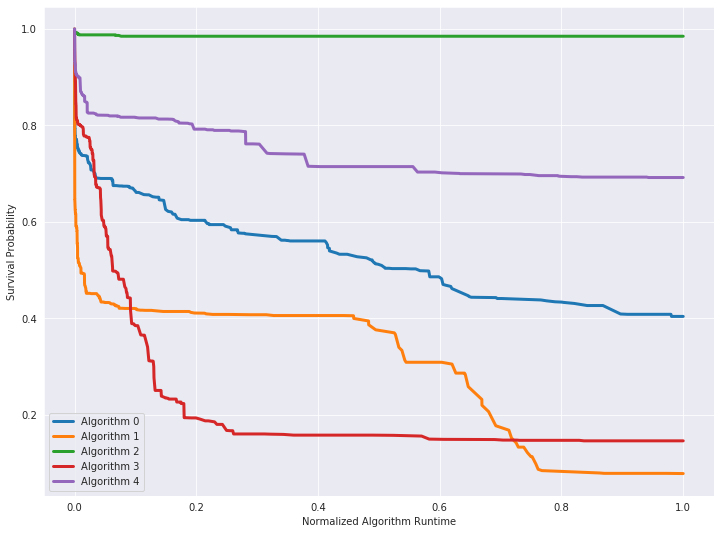

In [10]:
# set figure settings
fig, ax = plt.subplots(figsize=(12, 9))
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Normalized Algorithm Runtime')

# plot survival functions 
for alg_id in range(num_algorithms):
    events =  event_times[alg_id] / algorithm_cutoff_time
    sns.lineplot(x=events, y=survival_functions[alg_id], ax=ax, label='Algorithm {}'.format(alg_id))
    
fig.savefig(r'./survival_functions.pdf', bbox_inches='tight')
fig.show()

# Cumulated Risk Score Plots

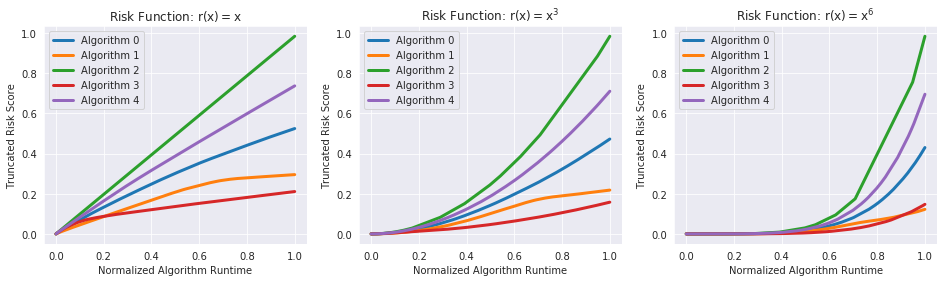

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
risk_funcs = [lambda x: x, lambda x: x**2, lambda x: x**5]
    
for ax_num, risk_func in enumerate(risk_funcs):
    axes[ax_num].ticklabel_format(useOffset=False, style='plain')
    axes[ax_num].set_ylabel('Truncated Risk Score')
    axes[ax_num].set_xlabel('Normalized Algorithm Runtime')
    if ax_num == 0:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x}$')
        
    elif ax_num == 1:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^3}$')

    else:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^6}$')
    
    for alg_id in range(num_algorithms):
        events = event_times[alg_id] / algorithm_cutoff_time
        risk_scores = np.cumsum(survival_functions[alg_id][:-1] * np.diff(risk_func(events)))
        sns.lineplot(x=events[1:], y=risk_scores, ax=axes[ax_num], label='Algorithm {}'.format(alg_id))

fig.savefig(r'./risk_functions.pdf', bbox_inches='tight')
fig.show()

# Cumulated Risk Score Plots (Algorithm 1 & 3)

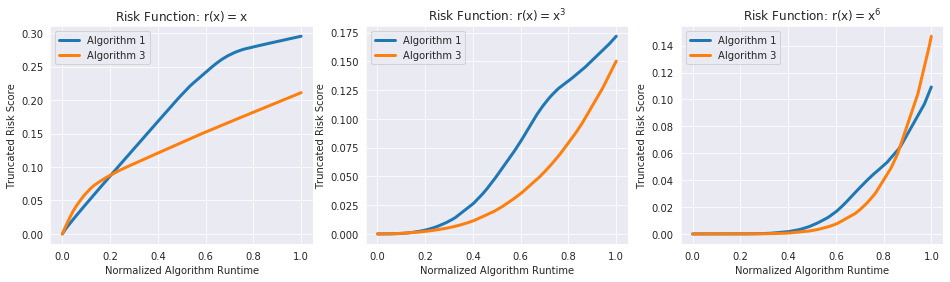

In [12]:
subset = [1, 3]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
risk_funcs = [lambda x: x, lambda x: x**3, lambda x: x**6]
    
for ax_num, risk_func in enumerate(risk_funcs):
    axes[ax_num].ticklabel_format(useOffset=False, style='plain')
    axes[ax_num].set_ylabel('Truncated Risk Score')
    axes[ax_num].set_xlabel('Normalized Algorithm Runtime')
    if ax_num == 0:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x}$')
        
    elif ax_num == 1:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^3}$')

    else:
        axes[ax_num].set_title('Risk Function: $\mathrm{r(x) = x^6}$')
    
    for alg_id in subset:
        events = event_times[alg_id] / algorithm_cutoff_time
        risk_scores = np.cumsum(survival_functions[alg_id][:-1] * np.diff(risk_func(events)))
        sns.lineplot(x=events[1:], y=risk_scores, ax=axes[ax_num], label='Algorithm {}'.format(alg_id))
        
fig.savefig(r'./subset_risk_functions.pdf', bbox_inches='tight')
fig.show()

# Cumulated Risk Score Difference (Algorithm 1 & 3)

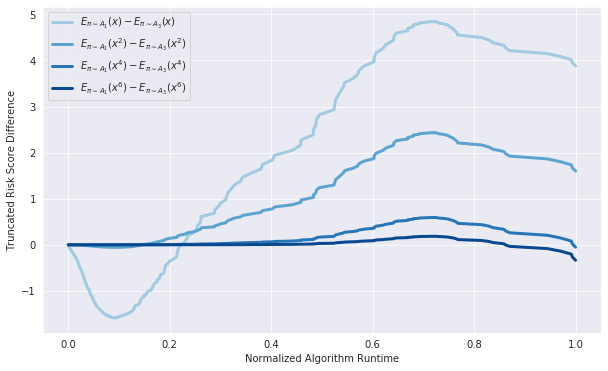

In [13]:
subset = [1, 3]
alg_0 = subset[0]
alg_1 = subset[1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_ylabel('Truncated Risk Score Difference')
ax.set_xlabel('Normalized Algorithm Runtime')

# compute all events occuring for algorithm 1 and algorithm 3
overall_events = set(event for alg_id in subset for event in event_times[alg_id].tolist())
overall_events.update([0.0, algorithm_cutoff_time])
overall_events = sorted(overall_events)

# compute all respective differences regarding the algorithms' survival probabilities
difference = np.zeros(len(overall_events))
for event_idx, event in enumerate(overall_events):
    # get index of respective survival probability for each algorithm
    idx = np.zeros(len(subset), dtype=int)
    for num, alg_id in enumerate(subset):
        idx[num] = np.argmax(event_times[alg_id] >= event)

    difference[event_idx] = survival_functions[alg_0][idx[0]] - survival_functions[alg_1][idx[1]]
    
overall_events = np.asarray(overall_events) / algorithm_cutoff_time

y1 = np.cumsum(difference * overall_events)
y2 = np.cumsum(difference * overall_events**2)
y3 = np.cumsum(difference * overall_events**4)
y4 = np.cumsum(difference * overall_events**6)

palette = sns.color_palette("Blues", 10)

sns.lineplot(x=overall_events, y=y1, ax=ax, label='$E_{\pi \sim A_1}(x) - E_{\pi \sim A_3}(x)$', color=palette[3])
sns.lineplot(x=overall_events, y=y2, ax=ax, label='$E_{\pi \sim A_1}(x^2) - E_{\pi \sim A_3}(x^2)$', color=palette[5])
sns.lineplot(x=overall_events, y=y3, ax=ax, label='$E_{\pi \sim A_1}(x^4) - E_{\pi \sim A_3}(x^4)$', color=palette[7])
sns.lineplot(x=overall_events, y=y4, ax=ax, label='$E_{\pi \sim A_1}(x^6) - E_{\pi \sim A_3}(x^6)$', color=palette[9])

fig.savefig(r'./risk_score_differences.pdf', bbox_inches='tight')
fig.show()

# Joint Plot

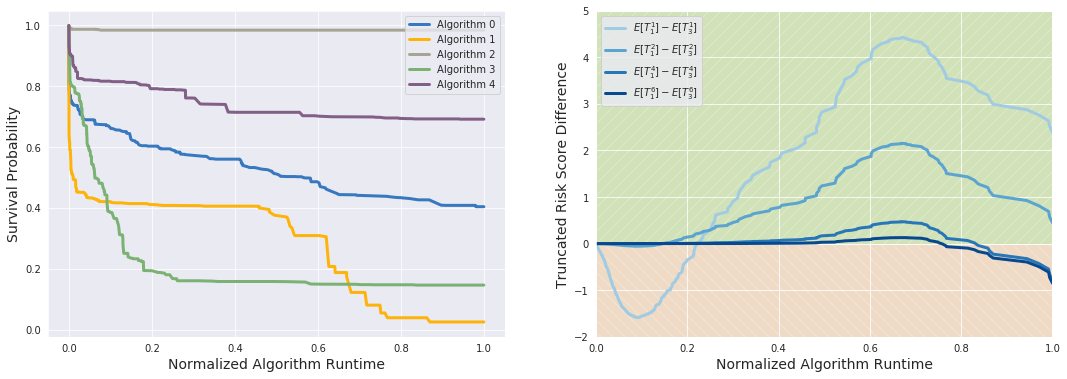

In [29]:
# set figure settings
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


### Survival Plot ###
axes[0].ticklabel_format(useOffset=False, style='plain')
axes[0].set_ylabel('Survival Probability', fontsize=14)
axes[0].set_xlabel('Normalized Algorithm Runtime', fontsize=14)

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
palette = sns.xkcd_palette(colors)

# plot survival functions 
for alg_id in range(num_algorithms):
    events =  event_times[alg_id] / algorithm_cutoff_time
    sns.lineplot(x=events, y=survival_functions[alg_id], ax=axes[0], label='Algorithm {}'.format(alg_id), color=palette[alg_id])
    
    
### Cumulated Risk Score Difference Plot ###
axes[1].set_ylim([-2.0, 5.0])
axes[1].set_xlim([0.0, 1.0])


subset = [1, 3]
alg_0 = subset[0]
alg_1 = subset[1]

axes[1].ticklabel_format(useOffset=False, style='plain')
axes[1].set_ylabel('Truncated Risk Score Difference',  fontsize=14)
axes[1].set_xlabel('Normalized Algorithm Runtime', fontsize=14)

# compute all events occuring for algorithm 1 and algorithm 3
overall_events = set(event for alg_id in subset for event in event_times[alg_id].tolist())
overall_events.update([0.0, algorithm_cutoff_time])
overall_events = sorted(overall_events)

# compute all respective differences regarding the algorithms' survival probabilities
difference = np.zeros(len(overall_events))
for event_idx, event in enumerate(overall_events):
    # get index of respective survival probability for each algorithm
    idx = np.zeros(len(subset), dtype=int)
    for num, alg_id in enumerate(subset):
        idx[num] = np.argmax(event_times[alg_id] >= event)

    difference[event_idx] = survival_functions[alg_0][idx[0]] - survival_functions[alg_1][idx[1]]
    
overall_events = np.asarray(overall_events) / algorithm_cutoff_time

y1 = np.cumsum(difference * overall_events)
y2 = np.cumsum(difference * overall_events**2)
y3 = np.cumsum(difference * overall_events**4)
y4 = np.cumsum(difference * overall_events**6)

palette = sns.color_palette("Blues", 10)

sns.lineplot(x=overall_events, y=y1, ax=axes[1], label='$E[T_1^1] - E[T_3^1]$', color=palette[3])
sns.lineplot(x=overall_events, y=y2, ax=axes[1], label='$E[T_1^2] - E[T_3^2]$', color=palette[5])
sns.lineplot(x=overall_events, y=y3, ax=axes[1], label='$E[T_1^4] - E[T_3^4]$', color=palette[7])
sns.lineplot(x=overall_events, y=y4, ax=axes[1], label='$E[T_1^6] - E[T_3^6]$', color=palette[9])

#fb1 = axes[1].fill_between([0.0, 1.0], y1=[0.0, 0.0], y2=[5.0, 5.0], facecolor="#f03838", zorder=0, alpha=0.3)
fb1 = axes[1].fill_between([0.0, 1.0], y1=[0.0, 0.0], y2=[5.0, 5.0], facecolor="#9ACD32", zorder=0, alpha=0.3)
fb1.set_hatch('//')

fb2 = axes[1].fill_between([0.0, 1.0], y1=[0.0, 0.0], y2=[-2.0, -2.0], facecolor="#fab75d", zorder=0, alpha=0.3)
fb2.set_hatch("\\\\")

fig.savefig(r'./joint_plot.pdf', bbox_inches='tight')
fig.show()

# Modification of Survival Functions in order to establish a clear example

In [22]:
survival_functions[1][-25:-23] = 0.20733033
survival_functions[1][-23:-20] = 0.18733033
survival_functions[1][-20:-18] = 0.1733033
survival_functions[1][-19:-16] = 0.12192181
survival_functions[1][-16:-10] = 0.080192181
survival_functions[1][-10:-7] = 0.05437217
survival_functions[1][-7:-4] = 0.03867688
survival_functions[1][-4:] = 0.0247688

# Setting Comparison

4it [01:43, 25.76s/it]


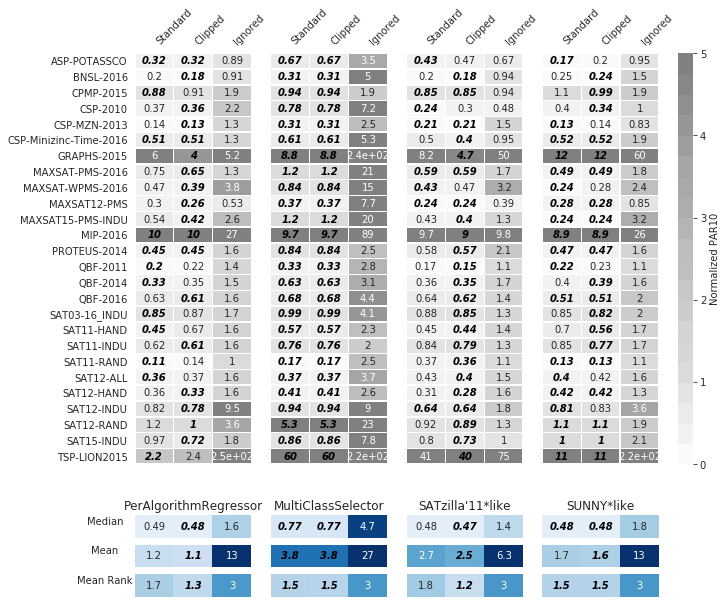

In [28]:
data = pd.read_csv(r'./setting_comparison.csv')

approaches = ['PerAlgorithmRegressor', 'MultiClassSelector', 'SATzilla\'11*like', 'SUNNY*like']
#approaches = ['PerAlgorithmRegressor', 'MultiClassSelector']

fig = plt.figure(figsize=(10, 10), constrained_layout=False)
num_cols = len(approaches) + 1
width_ratios = [40 for _ in range(len(approaches))]
width_ratios.append(5)

gs1 = gridspec.GridSpec(4, num_cols, width_ratios=width_ratios, height_ratios=[100, 5, 5, 5], figure=fig, wspace=0.2)
gs2 = gridspec.GridSpec(4, num_cols, width_ratios=width_ratios, height_ratios=[100, 5, 5, 5], figure=fig, wspace=0.2, hspace=0.05)

axes1 = [fig.add_subplot(gs1[0, num]) for num in range(num_cols)]


axes2 = [fig.add_subplot(gs2[1, num]) for num in range(num_cols - 1)]
axes3 = [fig.add_subplot(gs2[2, num]) for num in range(num_cols - 1)]
axes4 = [fig.add_subplot(gs2[3, num]) for num in range(num_cols - 1)]

palette = sns.color_palette(['#FAFAFA', '#F2F2F2', '#EBEBEB', '#E3E3E3', '#DBDBDB', '#D6D6D6', '#D4D4D4', '#CCCCCC', '#C7C7C7', '#BFBFBF', '#BDBDBD', '#B5B5B5', '#ADADAD', '#A9A9A9', '#A6A6A6', '#9E9E9E', '#969696', '#8F8F8F', '#878787', '#808080'], n_colors=20)
bottom_palette =sns.color_palette("Blues", n_colors=100)
vmin, vmax = 0.0, 5.0

for num, approach in tqdm(enumerate(approaches)):
    tmp_data = data.copy()
    tmp_data = tmp_data[tmp_data['Algorithm Selector'] == approach]
    tmp_data = tmp_data.pivot('ASlib Scenario','Algorithm Selector', ['Standard', 'Clipped', 'Ignored'])
    columns = ['Standard', 'Clipped', 'Ignored']
    tmp_data.columns = columns
    #tmp_data.columns=pd.MultiIndex.from_tuples(columns)
    
    if num + 1 < len(approaches):
        sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=axes1[num], annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=vmax, vmin=vmin, cbar=False)
    
    else:
        sns.heatmap(tmp_data, cmap=palette, linewidths=.5, ax=axes1[num], annot=True, cbar_kws={'label': 'Normalized PAR10'}, vmax=vmax, vmin=vmin, cbar_ax=axes1[-1])

    axes1[num].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)
    labels = axes1[num].get_xticklabels()
    axes1[num].set_xticklabels(labels, rotation=45, ha='left')
    axes1[num].set_xlabel('')
    axes1[num].set_ylabel('')    
    
    tmp = np.asarray(tmp_data.values, dtype=float)
    median = np.median(tmp, axis=0)    
    median = median.reshape(1, median.size)
    mean = np.mean(tmp, axis=0)
    mean = mean.reshape(1, mean.size)
    ranks = rankdata(tmp, axis=1)
    ranks = np.mean(ranks, axis=0)
    ranks = ranks.reshape(1, ranks.size)

    sns.heatmap(median, ax=axes2[num], annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=0.0, vmax=vmax)
    sns.heatmap(mean, ax=axes3[num], annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=0.0, vmax=vmax)
    sns.heatmap(ranks, ax=axes4[num], annot=True, cbar=False, xticklabels=False, yticklabels=False, cmap=bottom_palette, vmin=0.0, vmax=vmax)
    
    num_scenarios, num_settings = tmp.shape
    for scenario_id in range(num_scenarios):
        tmp_texts = axes1[num].texts[scenario_id * num_settings: scenario_id* num_settings + num_settings]
        min_val = min([float(text.get_text()) for text in tmp_texts])
        texts = [text for text in tmp_texts if float(text.get_text()) == min_val]
        
        for text in texts:
            #text.set_size(12)
            text.set_weight('bold')
            text.set_color('black')
            text.set_style('italic')

    
    for ax in [axes2[num], axes3[num], axes4[num]]:
        min_val = min([float(text.get_text()) for text in ax.texts])
        indices = [num for num, text in enumerate(ax.texts) if float(text.get_text()) == min_val]

        for idx in indices:
            text = ax.texts[idx]
            #text.set_size(12)
            text.set_weight('bold')
            text.set_color('black')
            text.set_style('italic')
    
    
    if num > 0:
        axes1[num].axes.get_yaxis().set_visible(False)

for ax in axes1[:-1]:
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
for num, ax in enumerate(axes2):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(approaches[num], y=1.3)
    
axes2[0].set_ylabel('Median', rotation=0, labelpad=30)
    
for ax in axes3:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
axes3[0].set_ylabel('Mean', rotation=0, labelpad=30)

for ax in axes4:
    ax.set_xlabel('')
    ax.set_ylabel('')

axes4[0].set_ylabel('Mean Rank', rotation=0, labelpad=30)

fig.savefig(r'./setting_comparison.pdf', bbox_inches='tight')
plt.show()

In [97]:
data = pd.read_csv(r'./setting_comparison.csv', header=None)
data.columns = ['ASlib Scenario', 'Algorithm Selector', 'Metric', 'Standard', 'Clipped', 'Ignored']

data = data.replace('sunny', 'SUNNY*like')
data = data.replace('satzilla-11', 'SATzilla\'11*like')
data = data.replace('isac', 'ISAC*like')
data = data.replace('per_algorithm_regressor', 'PerAlgorithmRegressor')
data = data.replace('MultiAlgorithmSelector', 'MultiClassSelector')

data.to_csv(r'./setting_comparison.csv', index=False)

In [114]:
data = pd.read_csv(r'./setting_comparison.csv')
data = data[data['ASlib Scenario'] != 'ASlib Scenario']
data.to_csv(r'./setting_comparison.csv', index=False)

In [117]:
data = pd.read_csv(r'./setting_comparison.csv')
data

,ASlib Scenario,Algorithm Selector,Metric,Standard,Clipped,Ignored
0,ASP-POTASSCO,SUNNY*like,par10,0.172295,0.198078,0.950941
1,ASP-POTASSCO,PerAlgorithmRegressor,par10,0.320221,0.317374,0.887766
2,ASP-POTASSCO,ISAC*like,par10,0.404677,0.404872,2.137459
3,ASP-POTASSCO,SATzilla'11*like,par10,0.428925,0.468827,0.665524
4,ASP-POTASSCO,MultiClassSelector,par10,0.666993,0.666993,3.451778
...,...,...,...,...,...,...
123,TSP-LION2015,PerAlgorithmRegressor,par10,2.155110,2.390995,247.356220
124,TSP-LION2015,ISAC*like,par10,9.902753,9.902745,259.254211
125,TSP-LION2015,SUNNY*like,par10,11.024178,11.024141,220.056476
126,TSP-LION2015,SATzilla'11*like,par10,41.317910,40.471242,74.736162
